In [17]:
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm  # Correct import fo ScalarMappable
import cartopy.crs as ccrs
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import glob
import re

import os
script_dir = os.getcwd()


## Load in the Arctic Ocean Physics Reanalysis

Data downloaded using the 'get_arctic_reanalysis.py" script with the copernicusmarine python api 

TOPAZ 4b arctic ocean reanalysis model. Spatial resolution ~ 11 km. January 1991 to December 2023.

Data clipped to bottom 200 m of the available data

https://data.marine.copernicus.eu/product/ARCTIC_MULTIYEAR_PHY_002_003/description

Latitude: [71.]
Longitude: [-54.]
Maximum depth of the model is 515.2494506835938 m


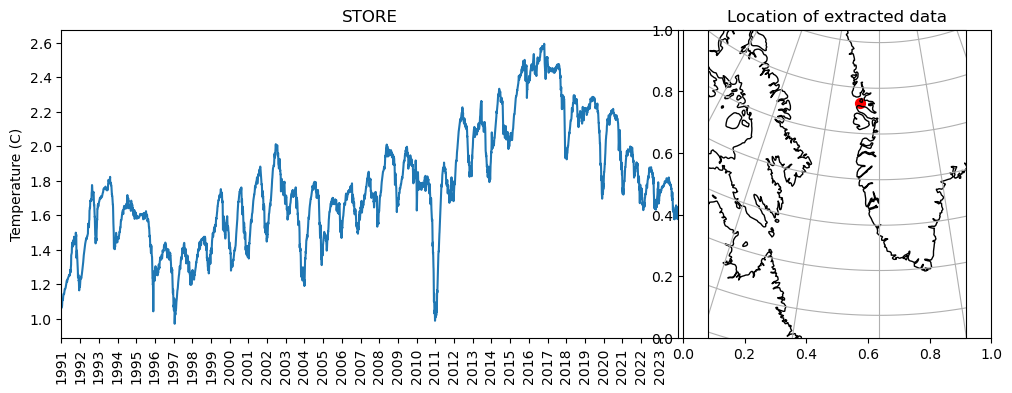

In [18]:
def load_arctic_reanalysis(glacier):
    # load the ocean reanalysis data
    ocean_reanalysis = xr.open_dataset('../data_for_repo_aug2025/Ocean_reanalysis/STORE_arc-phy-my-topaz4_data.nc')

    lat, lon = ocean_reanalysis['latitude'].values, ocean_reanalysis['longitude'].values
    print('Latitude: %s' % lat)
    print('Longitude: %s' % lon)

    max_depth = ocean_reanalysis['model_depth'].max().values
    print('Maximum depth of the model is %s m' % max_depth)

    # clip to bottom 200 m
    ocean_reanalysis_depth_clipped = ocean_reanalysis.sel(depth=slice(max_depth - 300, max_depth))
    average_temperature = ocean_reanalysis_depth_clipped['thetao'].mean(dim='depth')
    average_temperature['time'] = pd.to_datetime(average_temperature['time'].values)
    average_temperature_df = average_temperature.to_dataframe()
    average_temperature_df.index  = average_temperature.time

    # Quick plots to check data
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})
    fig.subplots_adjust(wspace=0.01)  # Adjust the width space between the subplots

    average_temperature_df['thetao'].plot(ax=ax[0])
    ax[0].set_title('%s' % glacier)
    ax[0].set_ylabel('Temperature (C)')
    ax[0].xaxis.set_major_locator(mdates.YearLocator())
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)

    projection = ccrs.Orthographic(central_longitude=-50, central_latitude=70)  # Orthographic projection centered on West Greenland
    ax[1] = plt.subplot(1, 2, 2, projection=projection)
    ax[1].coastlines(resolution='50m')
    ax[1].gridlines()
    ax[1].set_extent([-70, -40, 55, 75], ccrs.PlateCarree())  # Set the map extent to focus on West Greenland
    ax[1].scatter(lon, lat, color='red', s=50, transform=ccrs.PlateCarree())  # Plot the location data
    ax[1].set_title('Location of extracted data')

    return average_temperature_df

reanalysis_data = {}
reanalysis_data['STORE'] = load_arctic_reanalysis('STORE')
# reanalysis_data['KNS'] = load_arctic_reanalysis('KNS')

In [19]:
reanalysis_data['STORE']

,thetao
1991-01-01,1.063358
1991-01-02,1.064454
1991-01-03,1.065666
1991-01-04,1.066229
1991-01-05,1.066148
...,...
2023-12-27,1.630337
2023-12-28,1.635724
2023-12-29,1.641370
2023-12-30,1.645814


# Define functions for calulcating plume origin depth
1. Load in Ryan et al. 2015 grounding line depth data
2. Define functions to map groundng line to distance along ice front
3. Define functions to map plume coordinates to dist. along ice front and groundng line depth

In [20]:
# load in csv
gl_data = pd.read_csv('../data_for_repo_aug2025/Ryan_etal_2015_Store_bathymetry.csv')
gl_data = gl_data.sort_values(by='distance')
gl_data['distance'] = gl_data['distance'] * 1000  # convert km to m

import geopandas as gpd
# load in shapefile
shapefile_icefront = gpd.read_file('../data_for_repo_aug2025/STORE_icefront.shp')   
shapefile_icefront.crs = 'EPSG:4326'  

# shapefile_icefront is lat/lon in WGS84, convert to UTM for distance calculations
shapefile_icefront = shapefile_icefront.to_crs(epsg=3413)
line = shapefile_icefront.geometry.iloc[0]

# Or if you don't have substring, you can calculate cumulative distance:
icefront_data = pd.DataFrame([(x, y) for x, y in line.coords], columns=['x', 'y'])
# Calculate distance between consecutive points
icefront_data['dx'] = icefront_data['x'].diff()
icefront_data['dy'] = icefront_data['y'].diff()
icefront_data['segment_length'] = np.sqrt(icefront_data['dx']**2 + icefront_data['dy']**2)
icefront_data['distance'] = icefront_data['segment_length'].cumsum().fillna(0)

# 1. Ensure both datasets are sorted by distance
gl_data = gl_data.sort_values('distance')
icefront_data = icefront_data.sort_values('distance')

# 2. Find nearest grounding line depth for each icefront point
def find_nearest_depth(icefront_dist, gl_distances, gl_depths):
    """Returns depth from nearest grounding line point"""
    idx = np.abs(gl_distances - icefront_dist).argmin()
    return gl_depths.iloc[idx]

icefront_data['gl_depth'] = icefront_data['distance'].apply(
    lambda d: find_nearest_depth(d, gl_data['distance'], gl_data['depth'])
)

# 3. Calculate match quality (distance between matched points)
icefront_data['match_distance'] = icefront_data['distance'].apply(
    lambda d: np.abs(gl_data['distance'] - d).min()
)

def get_nearest_depth(lat, lon, shapefile, gl_data):
    # Convert input to GeoSeries in WGS84
    point = gpd.GeoSeries(
        gpd.points_from_xy([lon], [lat]), 
        crs="EPSG:4326"
    )
    
    # Reproject to same CRS as shapefile (UTM 3413 as per your earlier code)
    point_utm = point.to_crs(shapefile.crs)
    line = shapefile.geometry.iloc[0]  # Get the LineString
    
    nearest_point_on_line = line.interpolate(line.project(point_utm.iloc[0]))
    distance_along_line = line.project(nearest_point_on_line)
    
    # 3. Find closest grounding line point by distance
    gl_idx = np.abs(gl_data['distance'] - distance_along_line).argmin()
    
    return gl_data.iloc[gl_idx]['depth']

# Batch processing version
def batch_nearest_depths(coords, shapefile, gl_data):
    """Process multiple coordinates at once"""
    return [get_nearest_depth(lat, lon, shapefile, gl_data) 
            for lat, lon in coords]

def get_line_distance(lat, lon, shapefile):
    """Calculate distance along line for given coordinates"""
    point = gpd.GeoSeries(
        gpd.points_from_xy([lon], [lat]),
        crs="EPSG:4326"
    ).to_crs(shapefile.crs)
    line = shapefile.geometry.iloc[0]
    return line.project(line.interpolate(line.project(point.iloc[0])))


# Open Store timeseries

In [21]:
file_dir = os.path.join(script_dir, 'data', 'STORE_plume_timeseries', '*.csv')
file_dir = os.path.join(r'G:\My Drive\FINAL_PLUME_SST_manuscript_gdrive_data\STORE_plume_north', '*.csv')
files = glob.glob(file_dir)

#create empty dataframe to store all data
STORE_data = pd.DataFrame()
for file in files:
    
    data = pd.read_csv(file)

    # retrieve sensor name from column 'sensor', and take just the numeric part
    sensor = data['sensor'].iloc[0] 
    sensor = int(sensor.split('_')[1])

    # retrieve lat, lon from ".geo" column where each cell looks like: "{"type":"Point","coordinates":[-50.57969769287109,70.37258380713793]}"
    geo = data['.geo'].iloc[0]
    match = re.search(r'\[(-?\d+\.\d+),\s*(-?\d+\.\d+)\]', geo)
    if match:
        lat = float(match.group(2))
        lon = float(match.group(1))
    else:
        lat = None
        lon = None
    
    depth = get_nearest_depth(lat, lon, shapefile_icefront, gl_data)
    
    # create idctionary with rmse for each sensor
    rmse_dict = {
        4: 0.85,
        5: 0.85,
        7: 0.94,
        8: 0.93,
        9: 0.91,
    }    

    date = data['date'].iloc[0]
    date = pd.to_datetime(date)

    # error is the standard deviation of the SST values
    std = data['SST'].std()

    if pd.isna(std):
        error = rmse_dict.get(sensor, 0.85)
    else:
        error = std + rmse_dict.get(sensor, 0.85)


    SST = data['SST'].median()
    STORE_data = pd.concat([STORE_data, pd.DataFrame({'date': [date], 'SST': [SST], 'sensor': [sensor], 'error': [error], 'std' : [std], 'depth': [depth], 'lat': [lat], 'lon': [lon]})])

# remove duplicate dates
STORE_data = STORE_data.drop_duplicates(subset=['date'], keep='last')
# add "Landsat" in front of the sensor name
STORE_data['sensor'] = 'Landsat ' + STORE_data['sensor'].astype(str)
# sort by date
STORE_data = STORE_data.sort_values(by='date').reset_index(drop=True)
STORE_data = STORE_data[STORE_data['depth'] < -350]
STORE_data

,date,SST,sensor,error,std,depth,lat,lon
0,1985-07-01,1.195846,Landsat 5,1.178387,0.328387,-396.300319,70.388867,-50.617249
1,1985-07-03,1.407565,Landsat 5,0.850068,0.000068,-362.350361,70.392343,-50.614010
2,1987-06-30,1.355865,Landsat 5,0.850000,0.000000,-396.300319,70.389348,-50.618060
4,1993-07-07,0.052102,Landsat 5,1.181991,0.331991,-396.300319,70.387741,-50.622619
5,1993-07-16,0.339615,Landsat 5,1.155661,0.305661,-362.350361,70.392032,-50.621012
6,2002-07-01,1.067245,Landsat 7,1.238165,0.298165,-370.184977,70.390214,-50.614356
8,2005-08-08,1.668022,Landsat 7,1.284370,0.344370,-370.184977,70.390522,-50.616272
9,2006-07-28,2.396377,Landsat 7,1.282833,0.342833,-455.495121,70.383792,-50.601962
10,2008-06-15,1.733961,Landsat 7,1.291390,0.351390,-400.652876,70.386912,-50.618632
11,2008-07-15,1.664809,Landsat 7,1.410456,0.470456,-400.652876,70.387253,-50.617120


## Load in plume surface temperatures and plot timeseries

## Plot STORE timeseries

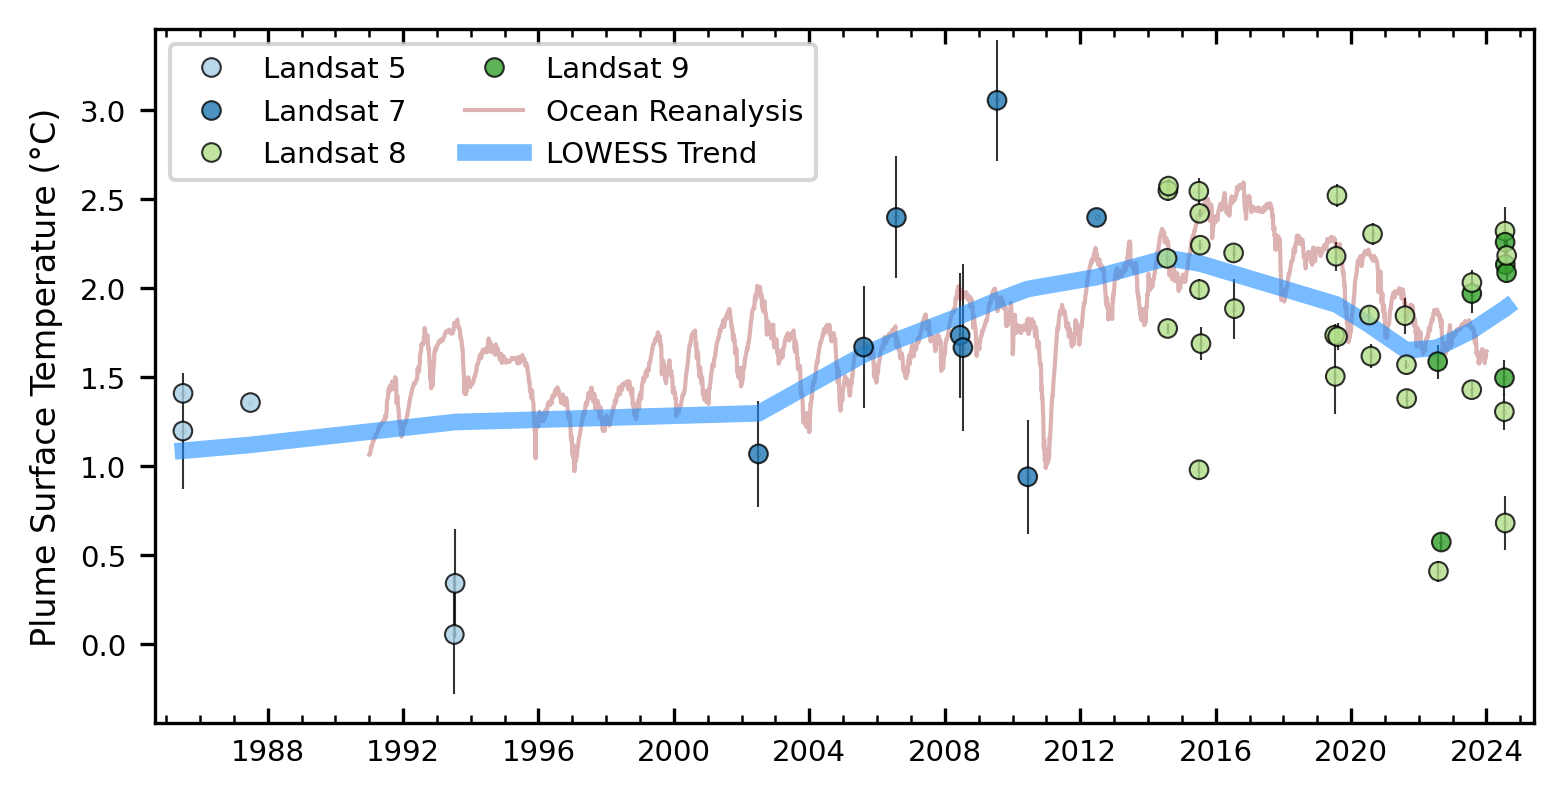

In [23]:
fig_width_mm = 135
fig_height_mm = 70  # Adjust height as needed
inches_per_mm = 0.0393701

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Roboto'

fig, ax = plt.subplots(figsize=(fig_width_mm * inches_per_mm, fig_height_mm * inches_per_mm), dpi=300)

sns.scatterplot(data=STORE_data, x='date', y='SST', hue='sensor',
                palette='Paired', s=20, edgecolor='black', linewidth=0.5, ax=ax, alpha=0.8)
# add error bars
ax.errorbar(STORE_data['date'], STORE_data['SST'], yerr=STORE_data['std'], fmt='o', color='black', alpha=0.8, markersize=0.1, capsize=0, elinewidth=0.5, zorder=-1)

# add ocean reanalysis data
average_temperature_df = reanalysis_data['STORE']
ax.plot(average_temperature_df.index, average_temperature_df['thetao'], color='darkred', label='Ocean Reanalysis', linewidth=1, alpha=0.3, zorder=-1)

# Add LOWESS trend line
lowess_smoothed = lowess(STORE_data['SST'], STORE_data['date'].astype(np.int64), frac=0.5)
ax.plot(STORE_data['date'], lowess_smoothed[:, 1], color='dodgerblue', label='LOWESS Trend',
            linewidth=4, zorder=-1, alpha=0.6)

# Set y-axis limits to the minimum and maximum SST values
ax.set_ylim(STORE_data['SST'].min() - 0.5, STORE_data['SST'].max() + 0.4)    

# Set x-axis limits to the start and end date of the SST data
start_date = STORE_data['date'].min() - pd.DateOffset(days=300)
end_date = STORE_data['date'].max() + pd.DateOffset(days=300)
ax.set_xlim(start_date, end_date)


# Formatting x-axis to show labels every year or every two years
# set minor ticks on x axis
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Change number to 1 for every year, 2 for every two years
ax.xaxis.set_major_locator(mdates.YearLocator(4))  # Change number to 1 for every year, 2 for every two years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# add xticks to the top x spine as well as the bottom but for the bottom they should be facing inwards
# ax.xaxis.set_ticks_position('top')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_tick_params(which='both', direction='in')
# ax.xaxis.set_ticks_position('both')

# change tick size
ax.tick_params(axis='both', which='major', labelsize=7)

# hide grid
ax.grid(False)

# set x axis label to none
ax.set_xlabel('')

# ax.axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax.set_ylabel('Plume Surface Temperature (°C)', fontsize=8)
ax.legend(loc='upper left', fontsize=7, ncol=2)
plt.setp(ax.get_xticklabels(), rotation=0)
plt.tight_layout()

# Save the plot as a PNG file
# fig.savefig(f'figures/STORE_timeseries_main.png', dpi=300)
plt.show()

In [24]:
# calculate stats for store plume surface temps 
STORE_data = STORE_data.sort_values('date').dropna()

mean = STORE_data['SST'].mean()
std = STORE_data['SST'].std()
median = STORE_data['SST'].median()
min_temp = STORE_data['SST'].min()
max_temp = STORE_data['SST'].max()
range = max_temp - min_temp
count = STORE_data['SST'].count()

print(f'--------- STORE Plume Surface Temperature Statistics: ---------')
print(f'Mean: {mean:.2f} °C')
print(f'Standard Deviation: {std:.2f} °C')
print(f'Median: {median:.2f} °C')
print(f'Minimum: {min_temp:.2f} °C')
print(f'Maximum: {max_temp:.2f} °C')
print(f'Range: {range:.2f} °C')
print(f'Count: {count}')

--------- STORE Plume Surface Temperature Statistics: ---------
Mean: 1.74 °C
Standard Deviation: 0.64 °C
Median: 1.75 °C
Minimum: 0.05 °C
Maximum: 3.05 °C
Range: 3.00 °C
Count: 50


# Analysis of Grounding line depth/ plume origin location

### Load in digitized grounding line depth along ice front from Ryan et al. 2015:
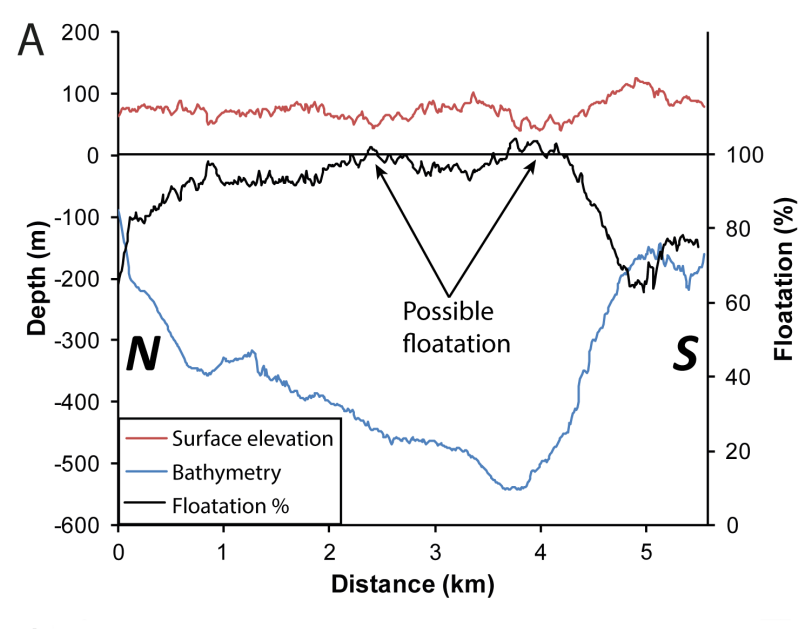

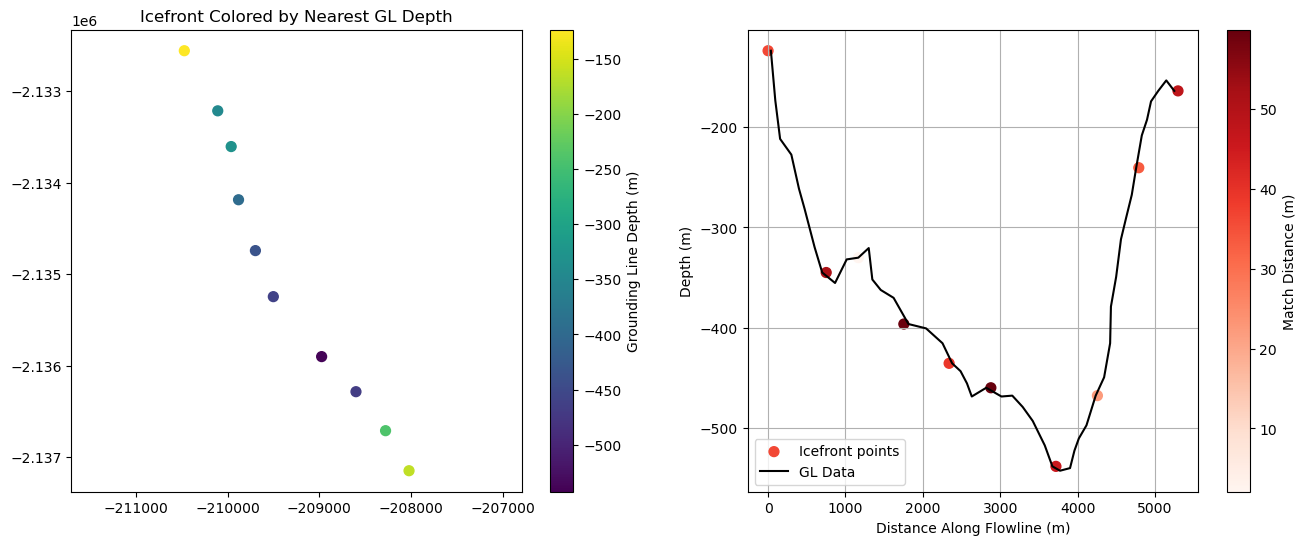

In [25]:
# load in csv
gl_data = pd.read_csv('../data_for_repo_aug2025/Ryan_etal_2015_Store_bathymetry.csv')
gl_data = gl_data.sort_values(by='distance')
gl_data['distance'] = gl_data['distance'] * 1000  # convert km to m

import geopandas as gpd
# load in shapefile
shapefile_icefront = gpd.read_file('../data_for_repo_aug2025/STORE_icefront.shp')   
shapefile_icefront.crs = 'EPSG:4326'  

# shapefile_icefront is lat/lon in WGS84, convert to UTM for distance calculations
shapefile_icefront = shapefile_icefront.to_crs(epsg=3413)
line = shapefile_icefront.geometry.iloc[0]

# Or if you don't have substring, you can calculate cumulative distance:
icefront_data = pd.DataFrame([(x, y) for x, y in line.coords], columns=['x', 'y'])
# Calculate distance between consecutive points
icefront_data['dx'] = icefront_data['x'].diff()
icefront_data['dy'] = icefront_data['y'].diff()
icefront_data['segment_length'] = np.sqrt(icefront_data['dx']**2 + icefront_data['dy']**2)
icefront_data['distance'] = icefront_data['segment_length'].cumsum().fillna(0)

# 1. Ensure both datasets are sorted by distance
gl_data = gl_data.sort_values('distance')
icefront_data = icefront_data.sort_values('distance')

# 2. Find nearest grounding line depth for each icefront point
def find_nearest_depth(icefront_dist, gl_distances, gl_depths):
    """Returns depth from nearest grounding line point"""
    idx = np.abs(gl_distances - icefront_dist).argmin()
    return gl_depths.iloc[idx]

icefront_data['gl_depth'] = icefront_data['distance'].apply(
    lambda d: find_nearest_depth(d, gl_data['distance'], gl_data['depth'])
)

# 3. Calculate match quality (distance between matched points)
icefront_data['match_distance'] = icefront_data['distance'].apply(
    lambda d: np.abs(gl_data['distance'] - d).min()
)

# 4. Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Geographic plot
sc = ax1.scatter(
    icefront_data['x'], icefront_data['y'], 
    c=icefront_data['gl_depth'], 
    cmap='viridis', 
    s=50,
    vmin=gl_data['depth'].min(), 
    vmax=gl_data['depth'].max()
)
plt.colorbar(sc, ax=ax1, label='Grounding Line Depth (m)')
ax1.set_title('Icefront Colored by Nearest GL Depth')
ax1.axis('equal')

# Distance-aligned plot
ax2.scatter(
    icefront_data['distance'], 
    icefront_data['gl_depth'],
    c=icefront_data['match_distance'],
    cmap='Reds',
    s=50,
    label='Icefront points'
)
ax2.plot(gl_data['distance'], gl_data['depth'], 'k-', label='GL Data')
ax2.set_xlabel('Distance Along Flowline (m)')
ax2.set_ylabel('Depth (m)')
plt.colorbar(ax2.collections[0], ax=ax2, label='Match Distance (m)')
ax2.legend()
ax2.grid(True)



### From coordinates of plume surface temperature extraction do the following:
1. Find the nearest point on the shapefile ice front line to those coordinates
2. Extract the grounding line depth at that location/ and distance along ice front

In [26]:
def get_nearest_depth(lat, lon, shapefile, gl_data):
    """
    Finds the nearest point on a shapefile line to given coordinates
    and returns the associated grounding line depth.
    
    Args:
        lat, lon (float): Input coordinates (WGS84)
        shapefile (GeoDataFrame): Line geometry of icefront
        gl_data (DataFrame): Grounding line data with 'distance' and 'depth'
        
    Returns:
        float: Depth at nearest point (meters)
    """
    # Convert input to GeoSeries in WGS84
    point = gpd.GeoSeries(
        gpd.points_from_xy([lon], [lat]), 
        crs="EPSG:4326"
    )
    
    # Reproject to same CRS as shapefile (UTM 3413 as per your earlier code)
    point_utm = point.to_crs(shapefile.crs)
    
    # Find closest point on line (3-step process)
    line = shapefile.geometry.iloc[0]  # Get the LineString
    
    # 1. Find nearest point on line
    nearest_point_on_line = line.interpolate(line.project(point_utm.iloc[0]))
    
    # 2. Calculate distance along line to this point
    distance_along_line = line.project(nearest_point_on_line)
    
    # 3. Find closest grounding line point by distance
    gl_idx = np.abs(gl_data['distance'] - distance_along_line).argmin()
    
    return gl_data.iloc[gl_idx]['depth']

# Batch processing version
def batch_nearest_depths(coords, shapefile, gl_data):
    """Process multiple coordinates at once"""
    return [get_nearest_depth(lat, lon, shapefile, gl_data) 
            for lat, lon in coords]

def get_line_distance(lat, lon, shapefile):
    """Calculate distance along line for given coordinates"""
    point = gpd.GeoSeries(
        gpd.points_from_xy([lon], [lat]),
        crs="EPSG:4326"
    ).to_crs(shapefile.crs)
    line = shapefile.geometry.iloc[0]
    return line.project(line.interpolate(line.project(point.iloc[0])))

In [27]:
# file_dir = os.path.join(script_dir, 'data', 'STORE_plume_timeseries', '*.csv')
file_dir = os.path.join(r'G:\My Drive\FINAL_PLUME_SST_manuscript_gdrive_data\combined', '*.csv') #Store_tiffs_FINAL_july2025_SOUTH_plumes_Plume_SST    Store_tiffs_FINAL_july2025_Plume_SST
files = glob.glob(file_dir)

#create empty dataframe to store all data
coordinates = []
for file in files:
    
    data = pd.read_csv(file)

    # retrieve sensor name from column 'sensor', and take just the numeric part
    sensor = data['sensor'].iloc[0] 
    sensor = int(sensor.split('_')[1])

    # retrieve lat, lon from ".geo" column where each cell looks like: "{"type":"Point","coordinates":[-50.57969769287109,70.37258380713793]}"
    geo = data['.geo'].iloc[0]
    match = re.search(r'\[(-?\d+\.\d+),\s*(-?\d+\.\d+)\]', geo)
    if match:
        lat = float(match.group(2))
        lon = float(match.group(1))
        coordinates.append((lat, lon))
    else:
        lat = None
        lon = None

depths = batch_nearest_depths(coordinates, shapefile_icefront, gl_data)



In [28]:
ensemble_dataset = xr.open_dataset('../data_for_repo_aug2025/CTD-PST_ensemble_data/STORE_plume_ensemble_2.nc')
ensemble_dataset

<xarray.Dataset> Size: 20MB
Dimensions:               (ensemble_run: 100, depth: 1000)
Coordinates:
  * depth                 (depth) int32 4kB 0 1 2 3 4 5 ... 995 996 997 998 999
  * ensemble_run          (ensemble_run) int32 400B 0 1 2 3 4 ... 95 96 97 98 99
Data variables: (12/26)
    z                     (ensemble_run, depth) float64 800kB ...
    b                     (ensemble_run, depth) float64 800kB ...
    u                     (ensemble_run, depth) float64 800kB ...
    T                     (ensemble_run, depth) float64 800kB ...
    S                     (ensemble_run, depth) float64 800kB ...
    N                     (ensemble_run, depth) float64 800kB ...
    ...                    ...
    QNB                   (ensemble_run, depth) float64 800kB ...
    HNB                   (ensemble_run, depth) float64 800kB ...
    alpha                 (ensemble_run, depth) float64 800kB ...
    Q0                    (ensemble_run, depth) float64 800kB ...
    grounding_line_depth  (ensemble_run, depth) float64 800kB ...
    mean_T                (depth) float64 8kB ...
Attributes:
    landsat_sst_min:            0.2962739467620849
    landsat_sst_max:            0.5531237721443176
    landsat_sst_mean:           0.38379836827516556
    landsat_sst_adjusted_min:   1.296273946762085
    landsat_sst_adjusted_max:   1.5531237721443176
    landsat_sst_adjusted_mean:  1.3837983682751656
    time_diff:                  23
    distance:                   3.677634045137311
    landsat_sst_error:          0.5289330417254295
    sst_time:                   2020-08-02
    ctd_time:                   2020-08-25
    CTD_before_SST:             False

C:\Users\s1834371\AppData\Local\Temp\ipykernel_15872\3929239763.py:29: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_main.plot(gl_data['distance'], gl_data['depth'],
C:\Users\s1834371\AppData\Local\Temp\ipykernel_15872\3929239763.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main.set_xticklabels([f'{x:.0f}' for x in xticks_km])
C:\Users\s1834371\AppData\Local\Temp\ipykernel_15872\3929239763.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


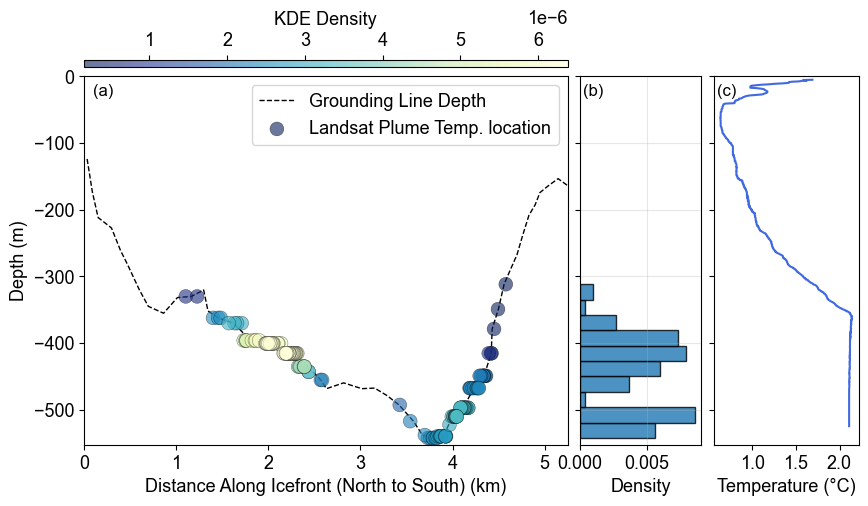

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


# 1. Main figure setup
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 13
fig = plt.figure(figsize=(10, 5))

# Create grid with 3 columns and dedicated colorbar space
gs = fig.add_gridspec(2, 3, width_ratios=[4, 1, 1.2], 
                     height_ratios=[0.02, 1],  # 15% for colorbar, rest for plots
                     hspace=0.05, wspace=0.05)

# Create axes
cbar_ax = fig.add_subplot(gs[0, 0])  # Colorbar on top of first column
ax_main = fig.add_subplot(gs[1, 0])  # Main plot
ax_hist = fig.add_subplot(gs[1, 1])  # Histogram
ax_ctd = fig.add_subplot(gs[1, 2])   # CTD plot

# 2. Main plot (grounding line with scatter)
distances = [get_line_distance(lat, lon, shapefile_icefront) for lat, lon in coordinates]
xy = np.vstack([distances, depths])
z = gaussian_kde(xy)(xy)
idx = z.argsort()

# Plot elements
ax_main.plot(gl_data['distance'], gl_data['depth'], 
            'k-', linewidth=1, linestyle='--', 
            label='Grounding Line Depth', zorder=-1)

sc = ax_main.scatter(
    np.array(distances)[idx],
    np.array(depths)[idx],
    c=z[idx],
    s=100,
    cmap='YlGnBu_r',
    alpha=0.6,
    edgecolors='k',
    linewidths=0.3,
    label='Landsat Plume Temp. location'
)

# Formatting
ax_main.set_xlabel('Distance Along Icefront (North to South) (km)')
ax_main.set_ylabel('Depth (m)')
ax_main.set_xlim(0, gl_data['distance'].max())
ax_main.set_ylim(gl_data['depth'].min()-10, 0)
ax_main.legend(loc='upper right')
ax_main.text(0.02, 0.98, '(a)', transform=ax_main.transAxes,
             fontsize=12, va='top', ha='left')

# convert xtick labels to km
# get xtick labels
xticks = ax_main.get_xticks()
# convert to km
xticks_km = xticks / 1000
# set xticks to km
ax_main.set_xticklabels([f'{x:.0f}' for x in xticks_km])


# 3. Colorbar (on top of main plot)
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', 
                    pad=0.01, aspect=30, shrink=0.5)
cbar.set_label('KDE Density', labelpad=5)
cbar_ax.xaxis.set_label_position('top')
cbar_ax.xaxis.set_ticks_position('top')

# 4. Histogram subplot
ax_hist.hist(depths, bins=10, orientation='horizontal',
            density=True, color='#1f78b4', 
            alpha=0.8, ec='black')
ax_hist.set_xlabel('Density')
ax_hist.yaxis.set_tick_params(labelleft=False)
ax_hist.grid(True, alpha=0.3)
ax_hist.set_ylim(ax_main.get_ylim())  # Match y-limits with main plot
ax_hist.text(0.02, 0.98, '(b)', transform=ax_hist.transAxes,
             fontsize=12, va='top', ha='left')

# 5. CTD subplot
CTD_temp = ensemble_dataset['Ta'].median(dim='ensemble_run')[::-1]
CTD_depth = ensemble_dataset['z'].median(dim='ensemble_run')[::-1]

ax_ctd.plot(CTD_temp, CTD_depth, color='royalblue', 
           linewidth=1.5, label='Temperature')
ax_ctd.set_xlabel('Temperature (°C)')
ax_ctd.set_ylim(ax_main.get_ylim())  # Match y-limits with main plot
# set ytick labels to none
ax_ctd.yaxis.set_tick_params(labelleft=False)
ax_ctd.text(0.02, 0.98, '(c)', transform=ax_ctd.transAxes,
             fontsize=12, va='top', ha='left')
ax_ctd.set_xticks(np.arange(1, 2.5, 0.5))

# savefigure
plt.tight_layout()  
# plt.savefig(r'%s\figures\STORE_plume_timeseries_plotting_june2025_S.png' % (script_dir), dpi=300, bbox_inches='tight')

Max value: 27, Half value: 13


C:\Users\s1834371\AppData\Local\Temp\ipykernel_15872\4274857426.py:49: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_main.plot(gl_data['distance'], gl_data['depth'],
C:\Users\s1834371\AppData\Local\Temp\ipykernel_15872\4274857426.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main.set_xticklabels([f'{x:.0f}' for x in xticks_km])
C:\Users\s1834371\AppData\Local\Temp\ipykernel_15872\4274857426.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap


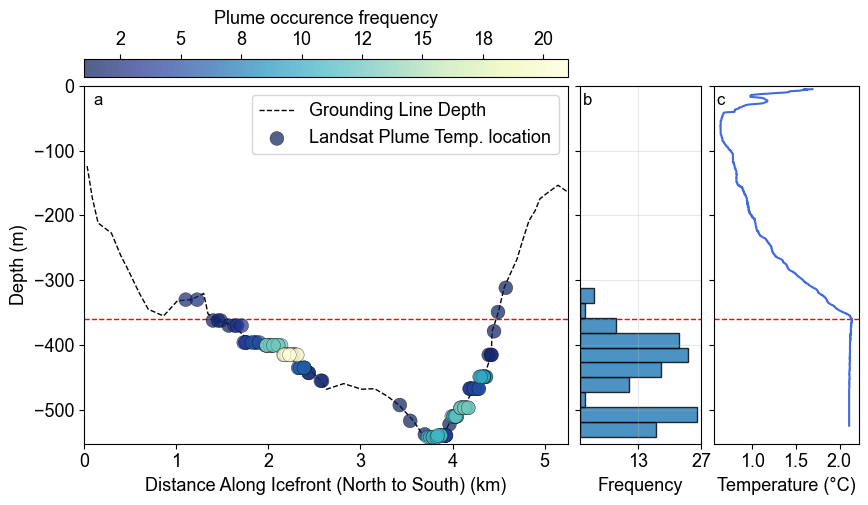

In [31]:
# ensemble_dataset = xr.open_dataset('%s/data/CTD-PST_ensemble_data/STORE_plume_ensemble_2.nc' % (script_dir))

# 1. Main figure setup
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 13
fig = plt.figure(figsize=(10, 5))

# Create grid with 3 columns and dedicated colorbar space
gs = fig.add_gridspec(2, 3, width_ratios=[4, 1, 1.2],
                      height_ratios=[0.05, 1],  # Space for colorbar
                      hspace=0.05, wspace=0.05)

# Create axes
cbar_ax = fig.add_subplot(gs[0, 0])  # Colorbar on top of first column
ax_main = fig.add_subplot(gs[1, 0])  # Main plot
ax_hist = fig.add_subplot(gs[1, 1])  # Histogram
ax_ctd = fig.add_subplot(gs[1, 2])   # CTD plot

# 2. Main plot (grounding line with scatter)

# --- MODIFICATION START: Calculate point frequency instead of KDE ---
# Define the number of bins for the 2D histogram. You can adjust this value.
# More bins = more granular density; fewer bins = more generalized density.
n_bins = 20

# Create a 2D histogram to count points in a grid
# H is the matrix of counts, xedges and yedges are the bin boundaries.
H, xedges, yedges = np.histogram2d(distances, depths, bins=n_bins)

# For each data point, find which bin it falls into
# np.digitize returns the index of the bin for each point.
x_indices = np.digitize(distances, xedges)
y_indices = np.digitize(depths, yedges)

# The indices must be within the bounds of the histogram matrix H.
# We clip them to ensure they are valid array indices.
x_indices = np.clip(x_indices, 1, H.shape[0]) - 1
y_indices = np.clip(y_indices, 1, H.shape[1]) - 1

# Assign the count (frequency) of its bin to each point.
point_frequencies = H[x_indices, y_indices]

# Sort points by frequency. This ensures that points in denser areas are plotted on top.
idx = point_frequencies.argsort()
# --- MODIFICATION END ---


# Plot elements
ax_main.plot(gl_data['distance'], gl_data['depth'],
             'k-', linewidth=1, linestyle='--',
             label='Grounding Line Depth', zorder=1)

sc = ax_main.scatter(
    np.array(distances)[idx],
    np.array(depths)[idx],
    c=point_frequencies[idx], # Color by the calculated point frequency
    s=100,
    cmap='YlGnBu_r',
    alpha=0.7,
    edgecolors='k',
    linewidths=0.3,
    label='Landsat Plume Temp. location',
    zorder=2
)

# Formatting
ax_main.set_xlabel('Distance Along Icefront (North to South) (km)')
ax_main.set_ylabel('Depth (m)')
ax_main.set_xlim(0, gl_data['distance'].max())
ax_main.set_ylim(min(gl_data['depth'])-10, 0)
ax_main.legend(loc='upper right')
ax_main.text(0.02, 0.98, 'a', transform=ax_main.transAxes,
             fontsize=12, va='top', ha='left')

# convert xtick labels to km
xticks = ax_main.get_xticks()
xticks_km = xticks / 1000
ax_main.set_xticklabels([f'{x:.0f}' for x in xticks_km])


# 3. Colorbar (on top of main plot)
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal',
                    pad=0.01, aspect=30, shrink=0.5, format='%.0f')
# make cbar tick labels intergers

# Update the colorbar label to reflect the new coloring scheme
cbar.set_label('Plume occurence frequency', labelpad=5)
cbar_ax.xaxis.set_label_position('top')
cbar_ax.xaxis.set_ticks_position('top')

# 4. Histogram subplot
ax_hist.hist(depths, bins=10, orientation='horizontal',
             density=False, color='#1f78b4',
             alpha=0.8, ec='black')
ax_hist.set_xlabel('Frequency')
ax_hist.yaxis.set_tick_params(labelleft=False)
ax_hist.grid(True, alpha=0.3)
ax_hist.set_ylim(ax_main.get_ylim())  # Match y-limits with main plot
# set ytikcs as max value and half of max value

    # max_val = int(round(ax_histy.get_xlim()[1], 1))
    # half_val = int(round(0.5 * ax_histy.get_xlim()[1], 1))
    # ax_histy.set_xticks([half_val, max_val])
    # ax_histy.set_xticklabels([half_val, max_val])

max_val = int(round(ax_hist.get_xlim()[1], 1))
half_val = int(round(0.5 * ax_hist.get_xlim()[1], 1))
print(f'Max value: {max_val}, Half value: {half_val}')
ax_hist.set_xlim(0, max_val)   
ax_hist.set_xticks([half_val, max_val])
ax_hist.set_xticklabels([half_val, max_val])

ax_hist.text(0.02, 0.98, 'b', transform=ax_hist.transAxes,
             fontsize=12, va='top', ha='left')

# 5. CTD subplot
CTD_temp = ensemble_dataset['Ta'].median(dim='ensemble_run')[::-1]
CTD_depth = ensemble_dataset['z'].median(dim='ensemble_run')[::-1]

ax_ctd.plot(CTD_temp, CTD_depth, color='royalblue',
            linewidth=1.5, label='Temperature')
ax_ctd.set_xlabel('Temperature (°C)')
ax_ctd.set_ylim(ax_main.get_ylim())  # Match y-limits with main plot
ax_ctd.yaxis.set_tick_params(labelleft=False)
ax_ctd.text(0.02, 0.98, 'c', transform=ax_ctd.transAxes,
             fontsize=12, va='top', ha='left')
ax_ctd.set_xticks(np.arange(1, 2.5, 0.5))

# add ax h line at 350 m depth on all plots as a red dotted line
for ax in [ax_main, ax_hist, ax_ctd]:
    ax.axhline(-360, color='red', linestyle='--', linewidth=1, zorder=0)
# savefigure
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
# Create figures directory if it doesn't exist
# os.makedirs('%s/figures' % (script_dir), exist_ok=True)
# plt.savefig(r'%s/figures/STORE_plume_frequency_plot_south.png' % (script_dir), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
# filter STORE_data to depths below 350 m
#create empty dataframe to store all data
STORE_data = pd.DataFrame()
for file in files:
    
    data = pd.read_csv(file)

    # retrieve sensor name from column 'sensor', and take just the numeric part
    sensor = data['sensor'].iloc[0] 
    sensor = int(sensor.split('_')[1])


    # retrieve lat, lon from ".geo" column where each cell looks like: "{"type":"Point","coordinates":[-50.57969769287109,70.37258380713793]}"
    geo = data['.geo'].iloc[0]
    match = re.search(r'\[(-?\d+\.\d+),\s*(-?\d+\.\d+)\]', geo)
    if match:
        lat = float(match.group(2))
        lon = float(match.group(1))
        coordinates.append((lat, lon))
    else:
        lat = None
        lon = None
    
    depth = get_nearest_depth(lat, lon, shapefile_icefront, gl_data)

    # create idctionary with rmse for each sensor
    rmse_dict = {
        4: 0.85,
        5: 0.85,
        7: 0.94,
        8: 0.93,
        9: 0.91,
    }    

    date = data['date'].iloc[0]
    date = pd.to_datetime(date)

    # error is the standard deviation of the SST values
    std = data['SST'].std()

    if pd.isna(std):
        error = rmse_dict.get(sensor, 0.85)
    else:
        error = std + rmse_dict.get(sensor, 0.85)


    SST = data['SST'].median()
    STORE_data = pd.concat([STORE_data, pd.DataFrame({'date': [date], 'SST': [SST], 'sensor': [sensor], 'error': [error], 'std' : [std], 'depth': [depth]})])

# remove duplicate dates
STORE_data = STORE_data.drop_duplicates(subset=['date'], keep='last')
# add "Landsat" in front of the sensor name
STORE_data['sensor'] = 'Landsat ' + STORE_data['sensor'].astype(str)
# sort by date
STORE_data = STORE_data.sort_values(by='date').reset_index(drop=True)
STORE_data

,date,SST,sensor,error,std,depth
0,1985-06-15,2.045931,Landsat 5,1.158221,0.308221,-349.292690
1,1985-06-22,2.455155,Landsat 5,1.162021,0.312021,-510.337299
2,1985-07-03,1.963681,Landsat 5,0.850244,0.000244,-497.279628
3,1987-06-30,1.355865,Landsat 5,1.041973,0.191973,-510.337299
4,1987-08-08,3.099492,Landsat 5,1.146304,0.296304,-539.934700
...,...,...,...,...,...,...
58,2019-08-02,2.513346,Landsat 8,0.975589,0.045589,-497.279628
59,2022-07-01,1.908054,Landsat 9,0.932611,0.022611,-449.401501
60,2022-07-24,1.952462,Landsat 9,0.985811,0.075811,-539.934700
61,2024-08-05,1.623037,Landsat 9,1.064838,0.154838,-542.546261


In [ ]:
# filter STORE_data to depths below -350 m
STORE_data = STORE_data[STORE_data['depth'] < -350]
# similar to the code below create a 2 x 2 subplot of a zoomed in timeseries plot of the plume surface temperature for the top 4 years with the most datS

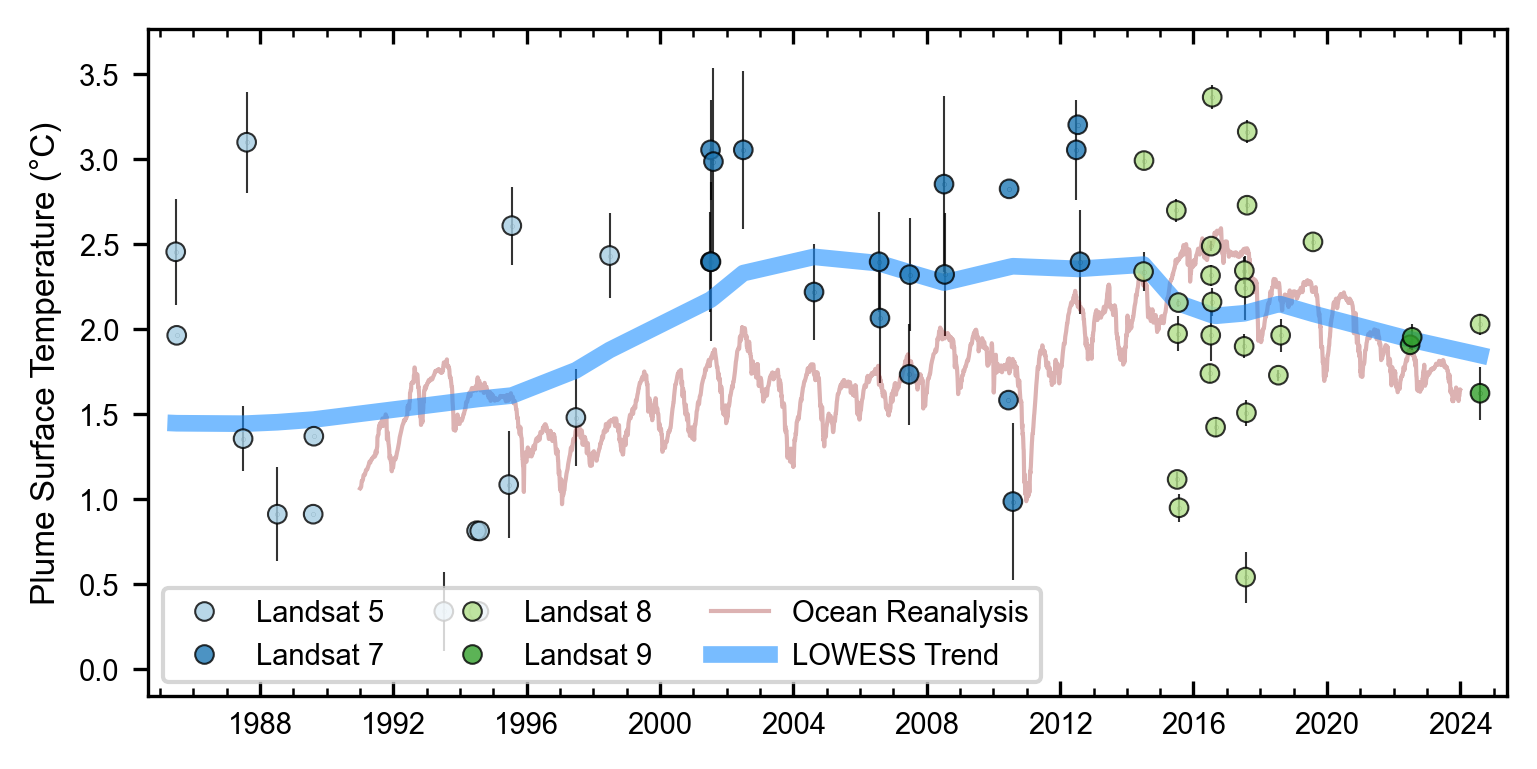

In [ ]:
fig_width_mm = 135
fig_height_mm = 70  # Adjust height as needed
inches_per_mm = 0.0393701

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Roboto'

fig, ax = plt.subplots(figsize=(fig_width_mm * inches_per_mm, fig_height_mm * inches_per_mm), dpi=300)

sns.scatterplot(data=STORE_data, x='date', y='SST', hue='sensor',
                palette='Paired', s=20, edgecolor='black', linewidth=0.5, ax=ax, alpha=0.8)
# add error bars
ax.errorbar(STORE_data['date'], STORE_data['SST'], yerr=STORE_data['std'], fmt='o', color='black', alpha=0.8, markersize=0.1, capsize=0, elinewidth=0.5, zorder=-1)

# add ocean reanalysis data
average_temperature_df = reanalysis_data['STORE']
ax.plot(average_temperature_df.index, average_temperature_df['thetao'], color='darkred', label='Ocean Reanalysis', linewidth=1, alpha=0.3, zorder=-1)

# Add LOWESS trend line
lowess_smoothed = lowess(STORE_data['SST'], STORE_data['date'].astype(np.int64), frac=0.4)
# ax.plot(STORE_data['date'], lowess_smoothed[:, 1], color='navy', label='LOWESS Trend',
#             linewidth=1.5, zorder=-1, alpha=0.8)

ax.plot(STORE_data['date'], lowess_smoothed[:, 1], color='dodgerblue', label='LOWESS Trend',
            linewidth=4, zorder=-1, alpha=0.6)

# Set y-axis limits to the minimum and maximum SST values
ax.set_ylim(STORE_data['SST'].min() - 0.5, STORE_data['SST'].max() + 0.4)    

# Set x-axis limits to the start and end date of the SST data
start_date = STORE_data['date'].min() - pd.DateOffset(days=300)
end_date = STORE_data['date'].max() + pd.DateOffset(days=300)
ax.set_xlim(start_date, end_date)


# Formatting x-axis to show labels every year or every two years
# set minor ticks on x axis
ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Change number to 1 for every year, 2 for every two years
ax.xaxis.set_major_locator(mdates.YearLocator(4))  # Change number to 1 for every year, 2 for every two years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# add xticks to the top x spine as well as the bottom but for the bottom they should be facing inwards
# ax.xaxis.set_ticks_position('top')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_tick_params(which='both', direction='in')
# ax.xaxis.set_ticks_position('both')

# change tick size
ax.tick_params(axis='both', which='major', labelsize=7)

# hide grid
ax.grid(False)

# set x axis label to none
ax.set_xlabel('')

# ax.axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax.set_ylabel('Plume Surface Temperature (°C)', fontsize=8)
ax.legend(loc='lower left', fontsize=7, ncol=3)
plt.setp(ax.get_xticklabels(), rotation=0)
plt.tight_layout()

# Save the plot as a PNG file
fig.savefig(f'figures/STORE_timeseries_S.png', dpi=300)
plt.show()

Top 10 years with the most SST data:
2016: 7 data points
2017: 7 data points
2015: 5 data points
2001: 4 data points
2010: 3 data points
2012: 3 data points
1994: 3 data points
1985: 2 data points
1987: 2 data points
2018: 2 data points
2001 - SST Range: 0.66 °C
2015 - SST Range: 1.75 °C
2017 - SST Range: 2.62 °C
2016 - SST Range: 1.94 °C


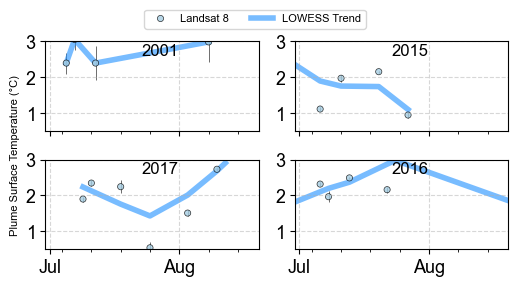

In [ ]:
# print the top ten years with the most SST data
top_years = STORE_data['date'].dt.year.value_counts().head(10)
print("Top 10 years with the most SST data:")
for year, count in top_years.items():
    print(f"{year}: {count} data points")

# similar to the code below create a 2 x 2 subplot of a zoomed in timeseries plot of the plume surface temperature for the top 4 years with the most data
top_years = STORE_data['date'].dt.year.value_counts().head(4).index
fig, axs = plt.subplots(2, 2, figsize=(fig_width_mm * inches_per_mm, fig_height_mm * inches_per_mm))
# set font size to 11
plt.rcParams['font.size'] = 11

# reverse order of top_years to plot the most recent year first
top_years = top_years[::-1]

axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration
for i, year in enumerate(top_years):
    # filter data for the year
    STORE_data_year = STORE_data[STORE_data['date'].dt.year == year]
    
    sns.scatterplot(data=STORE_data_year, x='date', y='SST', hue='sensor',
                    palette='Paired', s=20, edgecolor='black', linewidth=0.5, ax=axs[i], alpha=0.8)
    
    # add error bars
    axs[i].errorbar(STORE_data_year['date'], STORE_data_year['SST'], 
                    yerr=STORE_data_year['std'], fmt='o', color='black', 
                    alpha=0.8, markersize=0.1, capsize=0, elinewidth=0.5, zorder=-1)
    
    # Add LOWESS trend line
    lowess_smoothed_year = lowess(STORE_data_year['SST'], STORE_data_year['date'].astype(np.int64), frac=0.9)
    # axs[i].plot(STORE_data_year['date'], lowess_smoothed_year[:, 1], 
    #             color='navy', label='LOWESS Trend', linewidth=1.5, zorder=-1, alpha=0.8)
    
    axs[i].plot(STORE_data_year['date'], lowess_smoothed_year[:, 1], color='dodgerblue',
            linewidth=4, zorder=-1, alpha=0.6, label='LOWESS Trend')
    
    # Set y-axis limits to the minimum and maximum SST values
    axs[i].set_ylim(0.5,3)
    
    # set xlim from july to end of august of the year
    axs[i].set_xlim(pd.to_datetime(f'{year}-06-30'), pd.to_datetime(f'{year}-08-20'))
    # add ylabel
    axs[i].set_ylabel('Plume Surface Temperature (°C)', fontsize=8, y=1.05)
    
    # Formatting x-axis to show labels every month
    axs[i].xaxis.set_minor_locator(mdates.MonthLocator())
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Every 2
    # month
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    # minor locator to show every day
    axs[i].xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    axs[i].xaxis.set_minor_formatter(mdates.DateFormatter(''))

    # set xlabel to none
    axs[i].set_xlabel('')

    # set legend to none
    axs[i].legend().remove()

    # if top 2 plots then set xlabel ticks to none
    if i < 2:
        axs[i].set_xticklabels([])

    # add text box with year
    axs[i].text(0.45, 0.98, f'{year}', transform=axs[i].transAxes,
                fontsize=12, va='top', ha='left')

    # if right plots then set ylabel to none
    if i % 2 == 1:
        axs[i].set_ylabel('')
    axs[0].set_ylabel('')

    # add grid
    axs[i].grid(True, linestyle='--', alpha=0.5)

    # print range of SST for the year
    min_sst = STORE_data_year['SST'].min()
    max_sst = STORE_data_year['SST'].max()
    # print max - min SST for the year
    print(f"{year} - SST Range: {max_sst - min_sst:.2f} °C")

# add one legend for all plots to the side of the plots
handles, labels = axs[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=8, ncol=3, bbox_to_anchor=(0.7, 1.03), borderaxespad=0.)

# Adjust layout
plt.tight_layout()
# savefigure
plt.savefig(r'%s\figures\STORE_plume_timeseries_top_years_plotting_june2025_S.png' % (script_dir), dpi=300, bbox_inches='tight')



c:\Users\s1834371\AppData\Local\miniconda3\envs\c3_winterslowdown\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Text(0.5, 0, '')

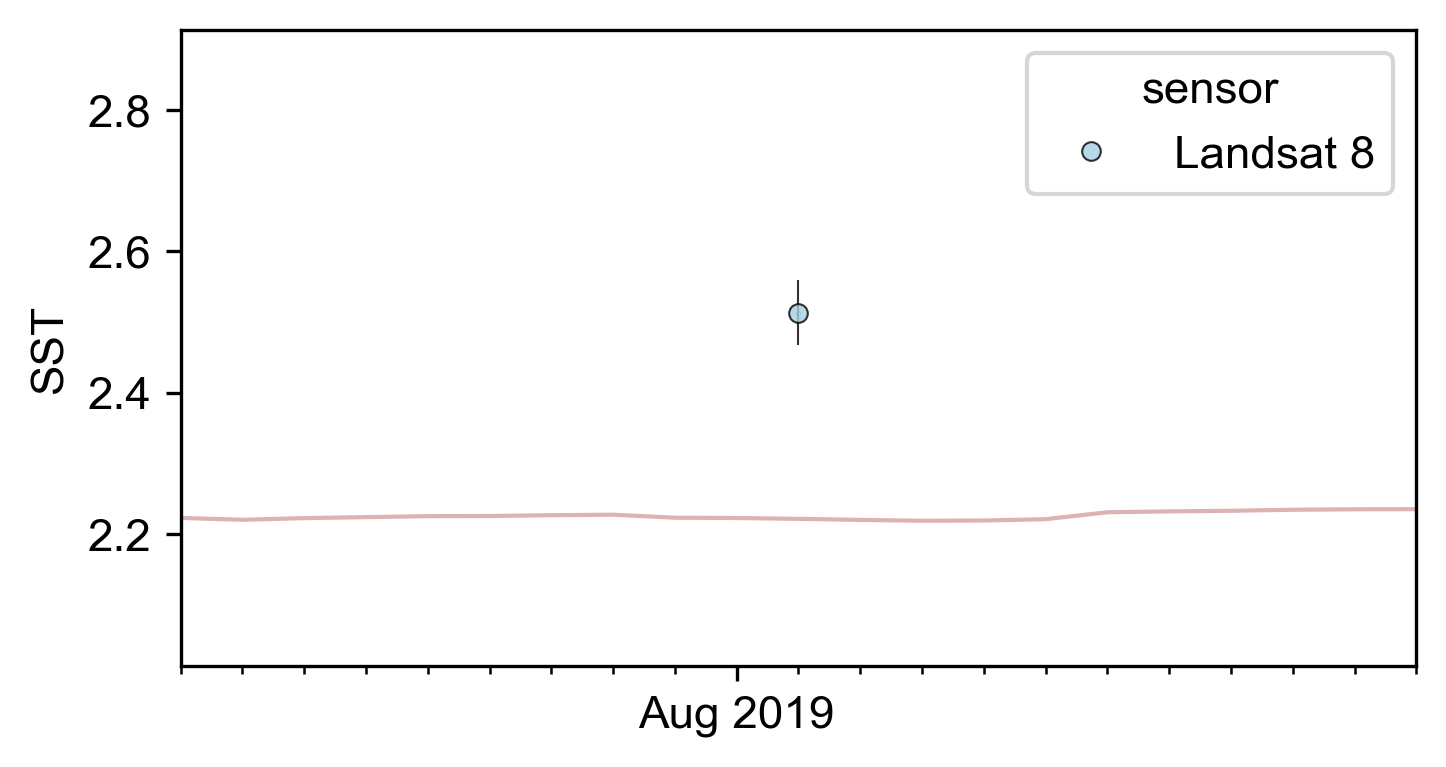

In [ ]:
# for the year 2019 plot a zoomed in timeseries plot of the plume surface temperature in the same style as the main plot
fig, ax = plt.subplots(figsize=(fig_width_mm * inches_per_mm, fig_height_mm * inches_per_mm), dpi=300)
# filter data for the year 2019
STORE_data_2019 = STORE_data[STORE_data['date'].dt.year == 2019]
sns.scatterplot(data=STORE_data_2019, x='date', y='SST', hue='sensor',
                palette='Paired', s=20, edgecolor='black', linewidth=0.5, ax=ax, alpha=0.8)
# add error bars
ax.errorbar(STORE_data_2019['date'], STORE_data_2019['SST'], 
            yerr=STORE_data_2019['std'], fmt='o', color='black', 
            alpha=0.8, markersize=0.1, capsize=0, elinewidth=0.5, zorder=-1)
# add ocean reanalysis data
average_temperature_df_2019 = average_temperature_df[average_temperature_df.index.year == 2019]
ax.plot(average_temperature_df_2019.index, average_temperature_df_2019['thetao'], 
        color='darkred', label='Ocean Reanalysis', linewidth=1, alpha=0.3, zorder=-1)
# Add LOWESS trend line
lowess_smoothed_2019 = lowess(STORE_data_2019['SST'], STORE_data_2019['date'].astype(np.int64), frac=0.4)
ax.plot(STORE_data_2019['date'], lowess_smoothed_2019[:, 1], 
        color='navy', label='LOWESS Trend', linewidth=1.5, zorder=-1, alpha=0.8)
# Set y-axis limits to the minimum and maximum SST values
ax.set_ylim(STORE_data_2019['SST'].min() - 0.5, STORE_data_2019['SST'].max() + 0.4)
# Set x-axis limits to the start and end date of the SST data
start_date_2019 = STORE_data_2019['date'].min() - pd.DateOffset(days=10)
end_date_2019 = STORE_data_2019['date'].max() + pd.DateOffset(days=10)
ax.set_xlim(start_date_2019, end_date_2019)
# Formatting x-axis to show labels every month
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# minor locator to show every day
ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))
ax.xaxis.set_minor_locator(mdates.DayLocator())
# set xlabel to none
ax.set_xlabel('')


--------- STORE Plume Surface Temperature Statistics: ---------
Mean: 2.03 °C
Standard Deviation: 0.76 °C
Median: 2.16 °C
Minimum: 0.34 °C
Maximum: 3.36 °C
Range: 3.02 °C
Count: 61

Seasonal Range Analysis (years with 3+ data points only):
Number of years included: 4
Mean Seasonal Range: 1.74 °C


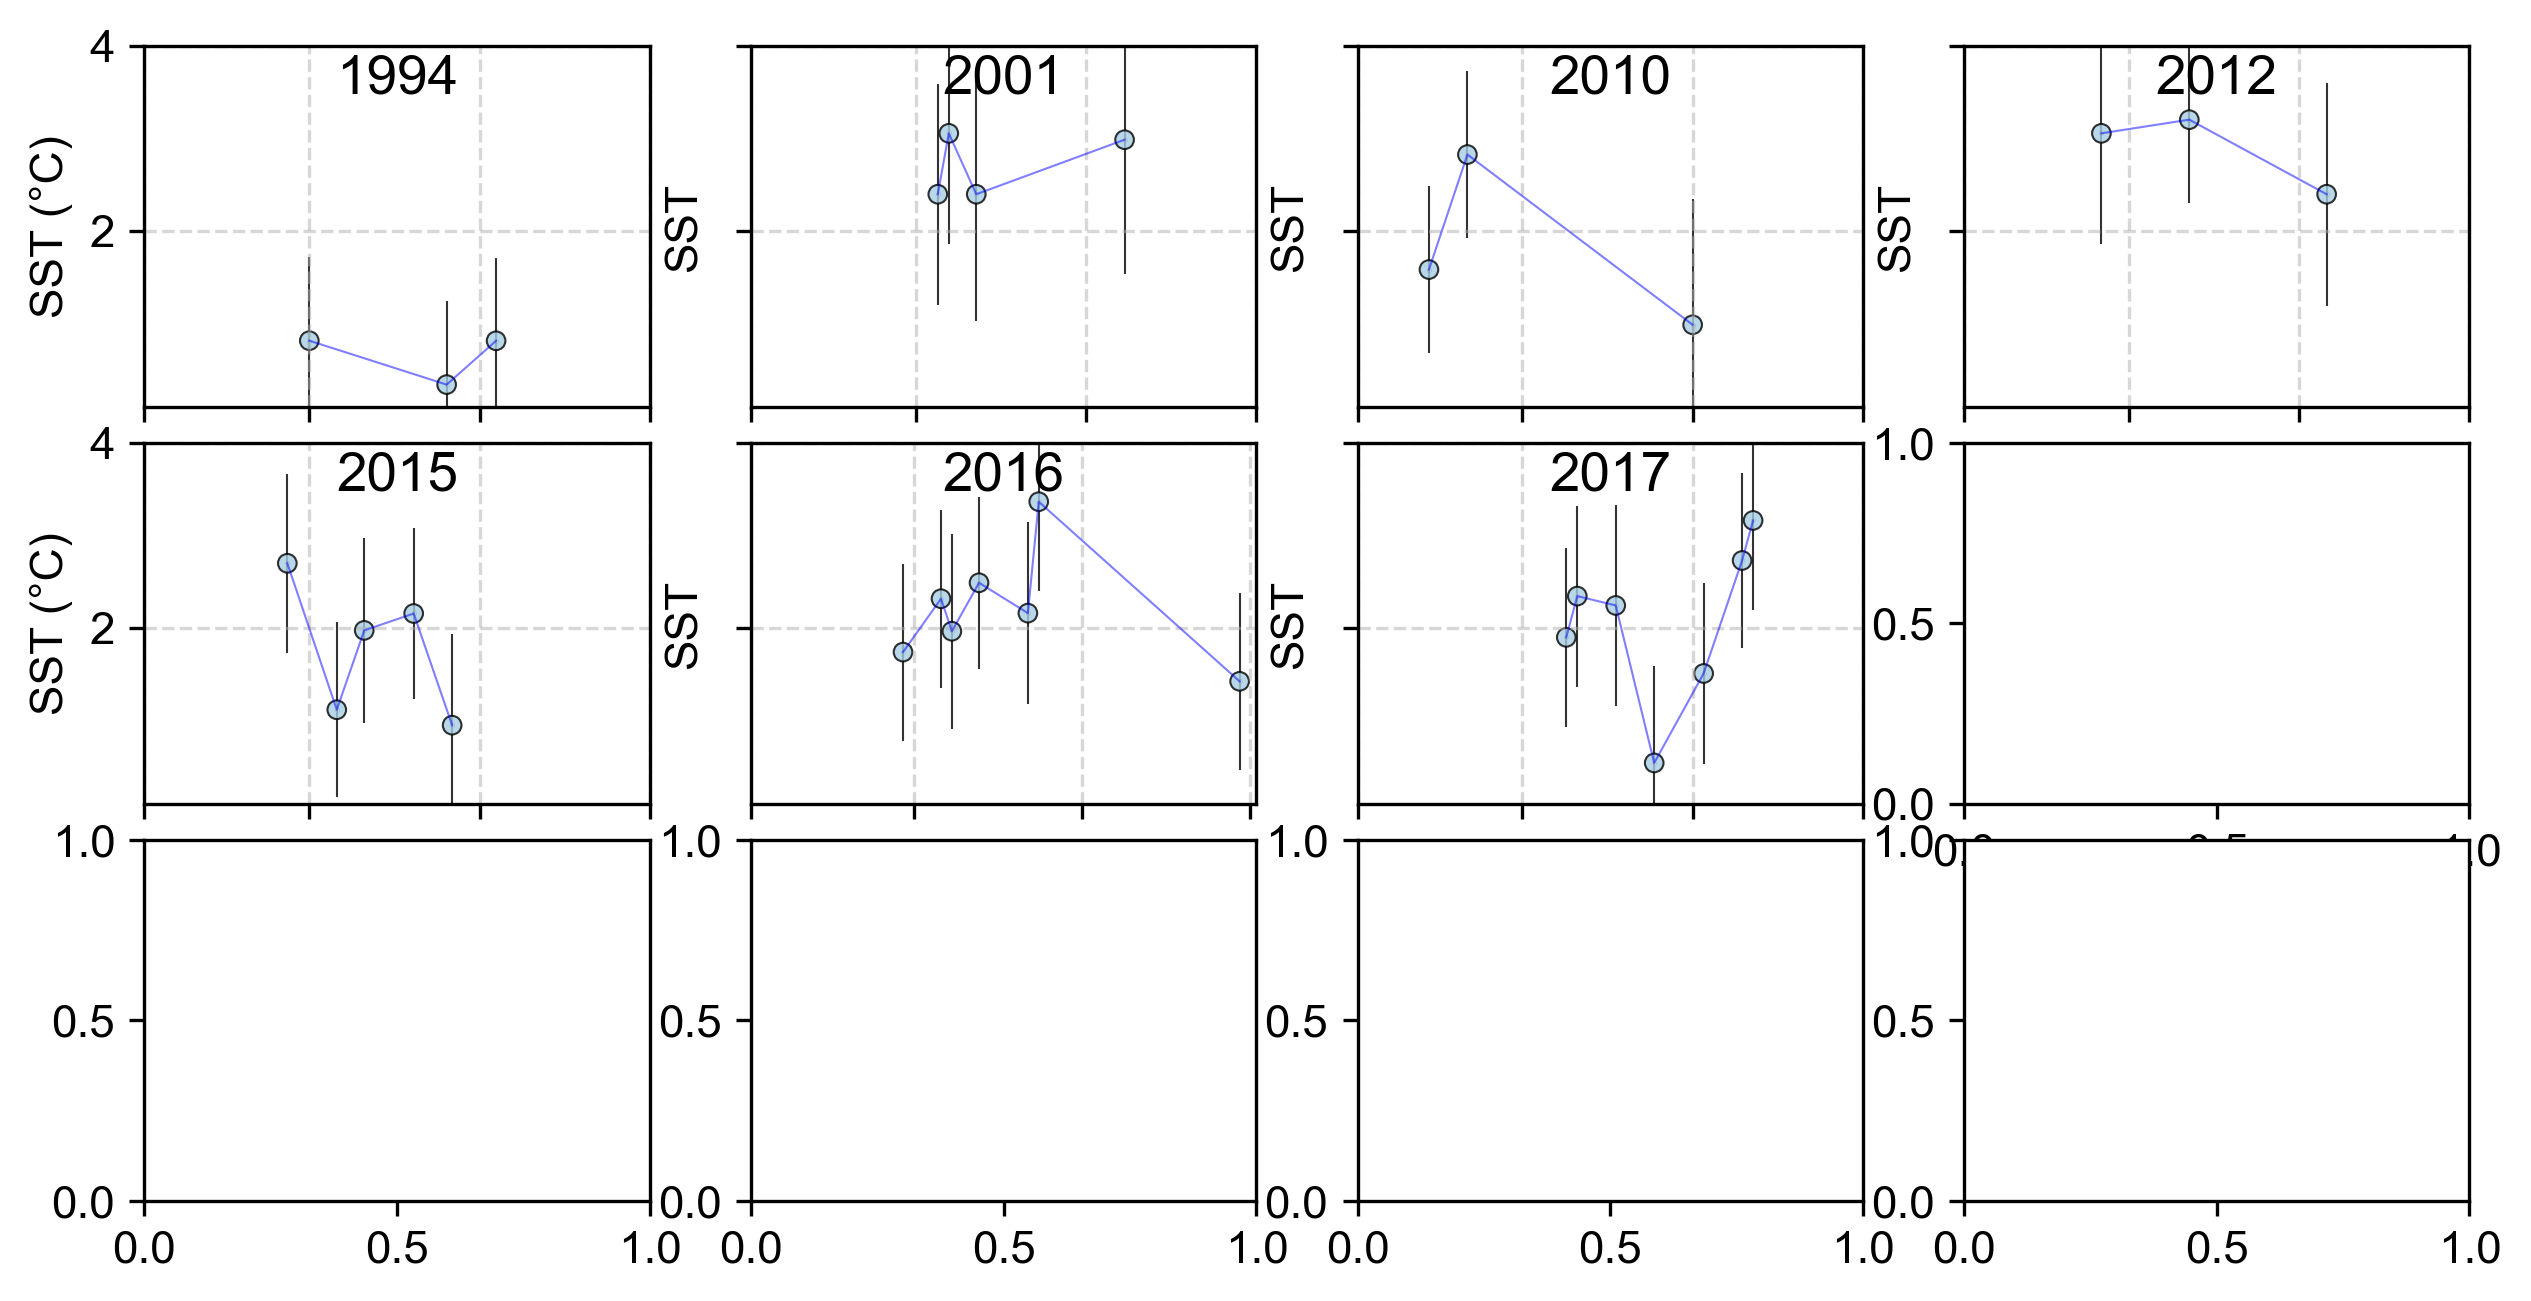

In [ ]:
# calculate stats for store plume surface temps 
STORE_data = STORE_data.sort_values('date').dropna()

mean = STORE_data['SST'].mean()
std = STORE_data['SST'].std()
median = STORE_data['SST'].median()
min_temp = STORE_data['SST'].min()
max_temp = STORE_data['SST'].max()
range = max_temp - min_temp
count = STORE_data['SST'].count()

print(f'--------- STORE Plume Surface Temperature Statistics: ---------')
print(f'Mean: {mean:.2f} °C')
print(f'Standard Deviation: {std:.2f} °C')
print(f'Median: {median:.2f} °C')
print(f'Minimum: {min_temp:.2f} °C')
print(f'Maximum: {max_temp:.2f} °C')
print(f'Range: {range:.2f} °C')
print(f'Count: {count}')

# for each year calculate the range (i.e. seasonal range) of SST values then calculate the mean of those ranges
STORE_data['year'] = STORE_data['date'].dt.year  # Extract year from date
yearly_counts = STORE_data.groupby('year')['SST'].count()
valid_years = yearly_counts[yearly_counts >= 4].index
filtered_data = STORE_data[STORE_data['year'].isin(valid_years)]
yearly_ranges = filtered_data.groupby('year')['SST'].agg(lambda x: x.max() - x.min())
mean_seasonal_range = yearly_ranges.mean()

print('\nSeasonal Range Analysis (years with 3+ data points only):')
print(f'Number of years included: {len(yearly_ranges)}')
print(f'Mean Seasonal Range: {mean_seasonal_range:.2f} °C')


## for each year plot the SST values but only include years with 3+ data points, it should be a subplot one plot per year, subplot should have 4 rows
years_with_3_data_points = yearly_counts[yearly_counts >= 3].index
# remove 2023 from the list of years
years_with_3_data_points = years_with_3_data_points[years_with_3_data_points != 2023]
fig, axs = plt.subplots(3, 4, figsize=(10, 5), dpi=300, gridspec_kw={'hspace': 0.1})
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy indexing
for i, year in enumerate(years_with_3_data_points):
    # skip 2023
    yearly_data = STORE_data[STORE_data['year'] == year]

    # error
    axs[i].errorbar(yearly_data['date'], yearly_data['SST'], yerr=yearly_data['std']+0.9, fmt='o', color='black', alpha=0.8, markersize=0.1, capsize=0, elinewidth=0.5, zorder=-3)
    axs[i].plot(yearly_data['date'], yearly_data['SST'], color='blue', linewidth=0.5, alpha=0.5)

    # sns scatterplot
    sns.scatterplot(data=yearly_data, x='date', y='SST', hue='sensor',
                    palette='Paired', s=20, edgecolor='black', linewidth=0.5, ax=axs[i], alpha=0.8, legend=False)

    axs[i].set_title(f'{year}', y=0.8)

    # if in the first column, set the y axis label
    if i % 4 == 0:
        axs[i].set_ylabel('SST (°C)')
    else:
        axs[i].set_yticklabels([])

    # if in the last row, set the x tick labels
    axs[i].set_xticks([pd.Timestamp(f'{year}-06-01'), pd.Timestamp(f'{year}-07-01'), pd.Timestamp(f'{year}-08-01'), pd.Timestamp(f'{year}-09-01')])

    if i >= 8:
        axs[i].xaxis.set_major_locator(mdates.MonthLocator())
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    else:
        # set x tick labels to none
        axs[i].set_xticklabels([])

    # set y lim from 0.5 to 3
    axs[i].set_ylim(0.1, 4)

    # add grid
    axs[i].grid(True, linestyle='--', alpha=0.5)

    # shows xticks of june, july, august, september
